In [1]:
pip install wandb

     |████████████████████████████████| 1.8MB 12.6MB/s 
     |████████████████████████████████| 133kB 45.0MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 174kB 45.0MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=aef71f89731e41f3ac8bef62de1ec439b9ce9f16c8b56230e7483fa20c45961b
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=a5745fbda3a3db5be18e0e633c7532e3ceee49492cef887a75056cb7c11cda78
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [2]:
import os
import cv2
import wandb
import time
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import albumentations as A
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch.nn.functional as F
from tqdm.auto import tqdm

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
torch.manual_seed(42)

In [5]:
# https://jessicastringham.net/2018/05/03/smallnorb/
import numpy as np
import struct

DATA_FOLDER = "/content/drive/MyDrive/SmallNorb/"

PREFIXES = {
    'train': 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

FILE_TYPES = ['info', 'cat', 'dat']

# helper function to read int from file
def read_int(f):
    num, = struct.unpack('i', f.read(4))
    return num


# From https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/ 
# "The magic number encodes the element type of the matrix"
# Note: I only copied over the ones I needed for these files.
map_magic_number_to_data_type = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

loaded_data = {}

for dataset, prefix in PREFIXES.items():
    for filetype in FILE_TYPES:
        filename = prefix + filetype + ".mat"
        print('Reading {}'.format(filename))
        
        file_loc = os.path.join(DATA_FOLDER, filename)
        with open( file_loc, 'rb') as f:
            # Read the magic_num, convert it to hexadecimal, and look up the data_type
            raw_magic_num = read_int(f)
            magic_num = format(raw_magic_num, '02x')
            data_type = map_magic_number_to_data_type[magic_num]
            print('dtype', data_type)

            # Read how many dimensions to expect
            ndim = read_int(f)
            
            # Read at least 3 ints, or however many ndim there are
            shape = [
                read_int(f)
                for i in range(max(ndim, 3))
            ]   
            # But in case ndims < 3, take at most n_dim elements
            shape = shape[:ndim]
            print('shape', shape)
    
            # Now load the actual data!
            loaded_data[(dataset, filetype)] = np.fromfile(
                f, 
                dtype=data_type, 
                count=np.prod(shape)
            ).reshape(shape)

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install kornia

from kornia.filters.kernels import (
    get_spatial_gradient_kernel2d, get_spatial_gradient_kernel3d, normalize_kernel2d
)


def spatial_gradient(input: torch.Tensor,
                     mode: str = 'sobel',
                     order: int = 1,
                     normalized: bool = True) -> torch.Tensor:
    r"""Computes the first order image derivative in both x and y using a Sobel
    operator.

    Args:
        input (torch.Tensor): input image tensor with shape :math:`(B, C, H, W)`.
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `sobel`.
        order (int): the order of the derivatives. Default: 1.
        normalized (bool): whether the output is normalized. Default: True.

    Return:
        torch.Tensor: the derivatives of the input feature map. with shape :math:`(B, C, 2, H, W)`.

    Examples:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = spatial_gradient(input)  # 1x3x2x4x4
        >>> output.shape
        torch.Size([1, 3, 2, 4, 4])
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) == 4:
        raise ValueError("Invalid input shape, we expect BxCxHxW. Got: {}"
                         .format(input.shape))
    # allocate kernel
    kernel: torch.Tensor = get_spatial_gradient_kernel2d(mode, order)
    if normalized:
        kernel = normalize_kernel2d(kernel)

    # prepare kernel
    b, c, h, w = input.shape
    tmp_kernel: torch.Tensor = kernel.to(input).detach()
    tmp_kernel = tmp_kernel.unsqueeze(1).unsqueeze(1)

    # convolve input tensor with sobel kernel
    kernel_flip: torch.Tensor = tmp_kernel.flip(-3)

    # Pad with "replicate for spatial dims, but with zeros for channel
    spatial_pad = [
        kernel.size(1) // 2,
        kernel.size(1) // 2,
        kernel.size(2) // 2,
        kernel.size(2) // 2
    ]
    out_channels: int = 3 if order == 2 else 2
    padded_inp: torch.Tensor = F.pad(
        input.reshape(b * c, 1, h, w), spatial_pad, 'replicate')[:, :, None]

    return F.conv3d(padded_inp, kernel_flip, padding=0).view(b, c, out_channels, h, w)



def spatial_gradient3d(input: torch.Tensor,
                       mode: str = 'diff',
                       order: int = 1) -> torch.Tensor:
    r"""Computes the first and second order volume derivative in x, y and d using a diff
    operator.

    Args:
        input (torch.Tensor): input features tensor with shape :math:`(B, C, D, H, W)`.
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `diff`.
        order (int): the order of the derivatives. Default: 1.

    Return:
        torch.Tensor: the spatial gradients of the input feature map.

    Shape:
        - Input: :math:`(B, C, D, H, W)`. D, H, W are spatial dimensions, gradient is calculated w.r.t to them.
        - Output: :math:`(B, C, 3, D, H, W)` or :math:`(B, C, 6, D, H, W)`

    Examples:
        >>> input = torch.rand(1, 4, 2, 4, 4)
        >>> output = spatial_gradient3d(input)
        >>> output.shape
        torch.Size([1, 4, 3, 2, 4, 4])
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) == 5:
        raise ValueError("Invalid input shape, we expect BxCxDxHxW. Got: {}"
                         .format(input.shape))
    # allocate kernel
    kernel: torch.Tensor = get_spatial_gradient_kernel3d(mode, order)

    # prepare kernel
    b, c, d, h, w = input.shape
    tmp_kernel: torch.Tensor = kernel.to(input).detach()
    tmp_kernel = tmp_kernel.repeat(c, 1, 1, 1, 1)

    # convolve input tensor with grad kernel
    kernel_flip: torch.Tensor = tmp_kernel.flip(-3)

    # Pad with "replicate for spatial dims, but with zeros for channel
    spatial_pad = [
        kernel.size(2) // 2,
        kernel.size(2) // 2,
        kernel.size(3) // 2,
        kernel.size(3) // 2,
        kernel.size(4) // 2,
        kernel.size(4) // 2
    ]
    out_ch: int = 6 if order == 2 else 3
    return F.conv3d(F.pad(
        input, spatial_pad, 'replicate'), kernel_flip, padding=0, groups=c).view(b, c, out_ch, d, h, w)



def sobel(input: torch.Tensor, normalized: bool = True, eps: float = 1e-6) -> torch.Tensor:
    r"""Computes the Sobel operator and returns the magnitude per channel.

    Args:
        input (torch.Tensor): the input image with shape :math:`(B,C,H,W)`.
        normalized (bool): if True, L1 norm of the kernel is set to 1.
        eps (float): regularization number to avoid NaN during backprop. Default: 1e-6.

    Return:
        torch.Tensor: the sobel edge gradient magnitudes map with shape :math:`(B,C,H,W)`.

    Example:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = sobel(input)  # 1x3x4x4
        >>> output.shape
        torch.Size([1, 3, 4, 4])
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) == 4:
        raise ValueError("Invalid input shape, we expect BxCxHxW. Got: {}"
                         .format(input.shape))

    # comput the x/y gradients
    edges: torch.Tensor = spatial_gradient(input, normalized=normalized)

    # unpack the edges
    gx: torch.Tensor = edges[:, :, 0]
    gy: torch.Tensor = edges[:, :, 1]

    # compute gradient maginitude
    magnitude: torch.Tensor = torch.sqrt(gx * gx + gy * gy + eps)

    return magnitude



class SpatialGradient(nn.Module):
    r"""Computes the first order image derivative in both x and y using a Sobel
    operator.

    Args:
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `sobel`.
        order (int): the order of the derivatives. Default: 1.
        normalized (bool): whether the output is normalized. Default: True.

    Return:
        torch.Tensor: the sobel edges of the input feature map.

    Shape:
        - Input: :math:`(B, C, H, W)`
        - Output: :math:`(B, C, 2, H, W)`

    Examples:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = SpatialGradient()(input)  # 1x3x2x4x4
    """

    def __init__(self,
                 mode: str = 'sobel',
                 order: int = 1,
                 normalized: bool = True) -> None:
        super(SpatialGradient, self).__init__()
        self.normalized: bool = normalized
        self.order: int = order
        self.mode: str = mode

    def __repr__(self) -> str:
        return self.__class__.__name__ + '('\
            'order=' + str(self.order) + ', ' + \
            'normalized=' + str(self.normalized) + ', ' + \
            'mode=' + self.mode + ')'

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return spatial_gradient(input, self.mode, self.order, self.normalized)



class SpatialGradient3d(nn.Module):
    r"""Computes the first and second order volume derivative in x, y and d using a diff
    operator.

    Args:
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `sobel`.
        order (int): the order of the derivatives. Default: 1.

    Return:
        torch.Tensor: the spatial gradients of the input feature map.

    Shape:
        - Input: :math:`(B, C, D, H, W)`. D, H, W are spatial dimensions, gradient is calculated w.r.t to them.
        - Output: :math:`(B, C, 3, D, H, W)` or :math:`(B, C, 6, D, H, W)`

    Examples:
        >>> input = torch.rand(1, 4, 2, 4, 4)
        >>> output = SpatialGradient3d()(input)
        >>> output.shape
        torch.Size([1, 4, 3, 2, 4, 4])
    """

    def __init__(self,
                 mode: str = 'diff',
                 order: int = 1) -> None:
        super(SpatialGradient3d, self).__init__()
        self.order: int = order
        self.mode: str = mode
        self.kernel = get_spatial_gradient_kernel3d(mode, order)
        return

    def __repr__(self) -> str:
        return self.__class__.__name__ + '('\
            'order=' + str(self.order) + ', ' + \
            'mode=' + self.mode + ')'

    def forward(self, input: torch.Tensor) -> torch.Tensor:  # type: ignore
        return spatial_gradient3d(input, self.mode, self.order)



class Sobel(nn.Module):
    r"""Computes the Sobel operator and returns the magnitude per channel.

    Args:
        normalized (bool): if True, L1 norm of the kernel is set to 1.
        eps (float): regularization number to avoid NaN during backprop. Default: 1e-6.

    Return:
        torch.Tensor: the sobel edge gradient magnitudes map.

    Shape:
        - Input: :math:`(B, C, H, W)`
        - Output: :math:`(B, C, H, W)`

    Examples:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = Sobel()(input)  # 1x3x4x4
    """

    def __init__(self,
                 normalized: bool = True, eps: float = 1e-6) -> None:
        super(Sobel, self).__init__()
        self.normalized: bool = normalized
        self.eps: float = eps

    def __repr__(self) -> str:
        return self.__class__.__name__ + '('\
            'normalized=' + str(self.normalized) + ')'

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return sobel(input, self.normalized, self.eps)

     |████████████████████████████████| 286kB 14.9MB/s 


In [7]:
transform = A.Compose([
    #A.RandomBrightnessContrast(p=0.6),    
    A.CenterCrop(width=69, height=69), 
    A.Resize(width=224,height=224),
    #A.CLAHE(p=0.5),
    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [8]:
class Toys(Dataset):
    
    def __init__(self,data,channels=3,transform=False):
        self.data=data
        self.transform=transform
        self.channels=channels
        
    def __len__(self):
        return len(self.data[('train', 'dat')])
    
    def __getitem__(self,idx):
        if self.channels==1:
            image = self.data[('train','dat')][idx][0]
            
        elif self.channels==2:
            image=self.data[('train','dat')][idx]
            band_3= np.zeros((96,96))
            image = np.dstack((image[0],image[1], band_3))
            image = image.astype('uint8')

        elif self.channels==3:
            image=self.data[('train','dat')][idx]
            band_1 = image[0]
            band_2 = image[1]
            img=torch.tensor(image,dtype=torch.float64)
            band_3  = Sobel()(img.unsqueeze(0))
            band_3 = np.asarray(band_3[0][0])
            image = np.dstack((band_1, band_2, band_3))
            
        image = image.astype('uint8')
        if self.transform is not False:
            dict=self.transform(image=image)
            image=dict['image']
            
        label= self.data[('train','cat')][idx]
        
        image=torch.tensor(image)#,dtype=torch.float64)
        label=torch.tensor(label,dtype=torch.float32)
        info = torch.tensor(loaded_data['train','info'][idx][1:],dtype=torch.float32)
        info[0]=info[0]#*5 + 30.
        info[1] = info[1]#*10.
        info[2]= info[2]#*1.
        if self.channels>1:
            image=image.permute(2,0,1)
        if self.channels==2:
            image=image[:2]
            
        image=image/255
        return image,info,label.long()
        

In [9]:
dataset=Toys(loaded_data,3,transform)

tensor(0)


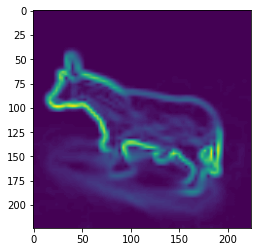

In [10]:
image,info,label=dataset[900]
plt.imshow(image[2])#.permute(1,2,0))
print(label)

In [11]:
class TestToys(Dataset):
    def __init__(self,data,channels=3):
        self.data=data
        self.channels=channels
        self.transform = A.Compose([A.CenterCrop(width=69, height=69),
                                    A.Resize(224,224),
                                   A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
    def __len__(self):
        return len(self.data[('test', 'dat')])
    
    def __getitem__(self,idx):
        
        if self.channels==1:
            image = self.data[('test','dat')][idx][0]
            
        elif self.channels==2:
            image=self.data[('test','dat')][idx]
            band_3= np.zeros((96,96))
            image = np.dstack((image[0],image[1], band_3))
            image = image.astype('uint8')
            
        elif self.channels==3:
            image=self.data[('test','dat')][idx]
            band_1 = image[0]
            band_2 = image[1]
            img=torch.tensor(image,dtype=torch.float64)
            band_3  = Sobel()(img.unsqueeze(0))
            band_3 = np.asarray(band_3[0][0])
            
            image = np.dstack((band_1, band_2, band_3))
            image = image.astype('uint8')
            
        image=image.astype('uint8')
        if self.transform is not False:
            dict=self.transform(image=image)
            image=dict['image']
            
        label= self.data[('test','cat')][idx]
        image=torch.tensor(image)
        label=torch.tensor(label,dtype=torch.float32)
        info = torch.tensor(loaded_data['test','info'][idx][1:],dtype=torch.float32)
        info[0]=info[0]#*5 + 30
        info[1] = info[1]#*10
        info[2]= info[2]#*1
        if self.channels>1:
            image=image.permute(2,0,1)
        if self.channels==2:
            image=image[:2]
        image=image/255  
        return image,info,label.long()

In [12]:
benchmark=TestToys(loaded_data,3)


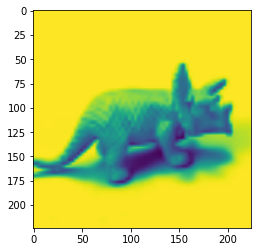

In [13]:
image,info,label=benchmark[0]
plt.imshow(image[1])#.permute(1,2,0))

In [14]:
train_length=int(0.75*len(dataset))

test_length=len(dataset)-train_length

train_dataset,val_dataset=torch.utils.data.random_split(dataset,(train_length,test_length))
train_length = int(0.75*len(train_dataset))
test_length = len(train_dataset)-train_length
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,(train_length,test_length))
batch_size= 32
trainloader = DataLoader(train_dataset,
        batch_size=batch_size, shuffle=True,num_workers= 2)
valloader = DataLoader(val_dataset,
        batch_size=batch_size, shuffle=True,num_workers=2)
testloader = DataLoader(benchmark,
        batch_size=batch_size, shuffle=False,num_workers=2)

In [15]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

print(device)

cuda


In [20]:
!git clone https://github.com/lukemelas/PyTorch-Pretrained-ViT.git

Cloning into 'PyTorch-Pretrained-ViT'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 231 (delta 113), reused 192 (delta 76), pack-reused 0
Receiving objects: 100% (231/231), 1.21 MiB | 8.60 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [21]:
%cd /content/PyTorch-Pretrained-ViT

/content/PyTorch-Pretrained-ViT


In [22]:
from pytorch_pretrained_vit import ViT
model = ViT('B_16', pretrained=True)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16.pth" to /root/.cache/torch/hub/checkpoints/B_16.pth



Loaded pretrained weights.


In [25]:
x=torch.randn(6,3,224,224)
y=torch.randn(6,3)
z=model(x,y)
z.shape

torch.Size([6, 5])

In [18]:
import torchvision.models as models
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [19]:
resnext50_32x4d

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [23]:
model_ft=nn.Sequential(*list(resnext50_32x4d.children())[:-1])
model_ft

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [24]:
class MyModel(nn.Module):
    def __init__(self, pretrained_model):
        super(MyModel, self).__init__()
        self.pretrained = pretrained_model
        self.linear = nn.Linear(2051,5)
    def forward(self, x,y):
        x = self.pretrained(x)
        #out = F.relu(x, inplace=True)
        #out = F.adaptive_avg_pool2d(out,output_size=(1,1))
        out = torch.flatten(x, 1)
        out=torch.cat((out,y),1)
        out = self.linear(out)
        return out

model = MyModel(model_ft)

In [26]:
def find_acc(pred, label):
    
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy

def train(network,criterion, optimizer, trainloader):
    loss_train = 0
    acc_train = 0
    network.train()

    #for step in tqdm(range(len(trainloader))):

    for idx,batch in enumerate(tqdm(trainloader)): 
    
        #images , labels = next(iter(trainloader))
        
        images,info, labels = batch[0],batch[1],batch[2]
        # move the images and labels to GPU
        images     = images.to(device)
        info = info.to(device)
        labels     = labels.to(device)
        
        pred = network(images,info)
      
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(pred , labels)
        
        # find accuracy
        acc_train_step = find_acc(pred, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        #scheduler.step()

        loss_train += loss_train_step.item()
        acc_train += acc_train_step  
            
    loss_train /= len(trainloader)
    acc_train /= len(trainloader)

    return loss_train, acc_train  
        
def validate(network,criterion, testloader): 
    loss_valid = 0
    acc_valid = 0       
    network.eval()  

    #for step in tqdm(range(len(testloader))):
    for idx,batch in enumerate(tqdm(testloader)):
         
        images,info ,labels = batch[0],batch[1],batch[2]
        # move the images and labels to GPU
        images     = images.to(device)
        info = info.to(device)
        labels     = labels.to(device)
        
        pred = network(images,info)
        
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_valid += loss_valid_step.item()
        acc_valid += acc_valid_step

    loss_valid /= len(testloader)
    acc_valid /= len(testloader)

    return loss_valid, acc_valid

def inference(network,criterion, testloader):
    loss_test = 0
    acc_test = 0       
    network.eval()  

    #for step in tqdm(range(len(testloader))):
    for idx,batch in enumerate(tqdm(testloader)):
         
        images,info, labels = batch[0],batch[1],batch[2]
        # move the images and labels to GPU
        images     = images.to(device)
        info = info.to(device)
        labels     = labels.to(device)
        
        pred = network(images,info)
    
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_test += loss_valid_step.item()
        acc_test += acc_valid_step

    loss_test /= len(testloader)
    acc_test /= len(testloader)
    return loss_test, acc_test

In [ ]:
wandb.init(name='75_SN1_ResNext',
           project='75_ResNext',
           notes='3 Channels with Augs,Sobel', 
           tags=['SGD','StepLR'],
           entity='creganstark')

# WandB Configurations (optional)        
wandb.config.lr = 1e-3
#model=model.float()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                      lr  =  1e-3)
                      #momentum     = 0.9,
                      #nesterov     = True,
                      #weight_decay = 1e-4)

#scheduler = optim.lr_scheduler.CyclicLR(optimizer,base_lr=5e-5,max_lr=5e-4 ,step_size_up=2000)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
# Log the network weight histograms (optional)
#.watch(model)

num_epochs = 15
start_time = time.time()
prev_acc=0
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(model, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(model, criterion, valloader)
    loss_test, acc_test = inference(model,criterion,testloader)
    scheduler.step()
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f} Test Loss: {:.4f}  Test Acc: {:.4f} '.format(epoch, loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test))

    #Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Test Loss": loss_test,
        "Test Acc": acc_test})
    if acc_test>prev_acc:
      prev_acc=acc_test
      acc_test=str(acc_test)
      paths = "test"+acc_test[:7]+".pt"
      print('Saving Model')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

wandb: Currently logged in as: creganstark (use `wandb login --relogin` to force relogin)



Epoch: 1  Train Loss: 0.1316  Train Acc: 95.9112  Valid Loss: 0.3269  Valid Acc: 93.2255 Test Loss: 0.9501  Test Acc: 83.6924 
Saving Model



Epoch: 2  Train Loss: 0.0704  Train Acc: 97.9629  Valid Loss: 0.0214  Valid Acc: 99.3226 Test Loss: 0.3250  Test Acc: 91.3967 
Saving Model



Epoch: 3  Train Loss: 0.0289  Train Acc: 99.0508  Valid Loss: 0.2375  Valid Acc: 94.7889 Test Loss: 1.4547  Test Acc: 81.2445 



Epoch: 4  Train Loss: 0.0359  Train Acc: 98.7588  Valid Loss: 0.0050  Valid Acc: 99.8470 Test Loss: 0.3128  Test Acc: 91.2637 



Epoch: 5  Train Loss: 0.0352  Train Acc: 98.9194  Valid Loss: 0.0076  Valid Acc: 99.7378 Test Loss: 0.2866  Test Acc: 93.5033 
Saving Model



Epoch: 6  Train Loss: 0.0365  Train Acc: 98.9413  Valid Loss: 0.0012  Valid Acc: 99.9344 Test Loss: 0.2508  Test Acc: 92.2615 



Epoch: 7  Train Loss: 0.0051  Train Acc: 99.8321  Valid Loss: 0.0016  Valid Acc: 99.9344 Test Loss: 0.1795  Test Acc: 94.5395 
Saving Model



Epoch: 8  Train Loss: 0.0105  Train Acc: 99.6787  Valid Loss: 0.0140  Valid Acc: 99.4100 Test Loss: 0.2970  Test Acc: 92.6645 



Epoch: 9  Train Loss: 0.0142  Train Acc: 99.5765  Valid Loss: 0.0029  Valid Acc: 99.8907 Test Loss: 0.4112  Test Acc: 90.4345 



Epoch: 10  Train Loss: 0.0166  Train Acc: 99.5108  Valid Loss: 0.0068  Valid Acc: 99.7596 Test Loss: 0.4107  Test Acc: 91.5666 



Epoch: 11  Train Loss: 0.0032  Train Acc: 99.9416  Valid Loss: 0.0008  Valid Acc: 99.9781 Test Loss: 0.1319  Test Acc: 96.1266 
Saving Model


In [ ]:
num_layers=6


In [ ]:
#for i in range(1):
model = ViT(
  image_size = 32,
  patch_size = 4,
  num_classes = 10,
  dim = 512,
  depth = 8,
  heads = 8,
  mlp_dim = 512,
  dropout = 0.1,
  emb_dropout = 0.1
)

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
#lr = 0.01
optimizer = optim.SGD(model.parameters(),
                      lr           = 0.001, 
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)

#opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
epochs = 40
epoch_loss,val_loss=trainingloop(epochs,trainloader,testloader,optimizer)
path = "model"+'1024_8l'+".pt"
print('Saving Model')
torch.save({
          'epoch': epochs,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': val_loss,
          'epoch_loss':epoch_loss,
          }, '/content/drive/MyDrive/logs/'+str(path))

STARTED TRAINING..
Epoch 1
Val Accuracy:  0.16 Validation_Loss: 88.3 Train Accuracy: 0.13 Train_loss: 449.01
Epoch 2
Val Accuracy:  0.22 Validation_Loss: 83.6 Train Accuracy: 0.18 Train_loss: 424.63
Epoch 3
Val Accuracy:  0.22 Validation_Loss: 83.3 Train Accuracy: 0.2 Train_loss: 413.18
Epoch 4
Val Accuracy:  0.2 Validation_Loss: 86.2 Train Accuracy: 0.21 Train_loss: 408.26
Epoch 5
Val Accuracy:  0.19 Validation_Loss: 85.8 Train Accuracy: 0.22 Train_loss: 405.0
Epoch 6
Val Accuracy:  0.27 Validation_Loss: 79.4 Train Accuracy: 0.23 Train_loss: 400.8
Epoch 7
Val Accuracy:  0.24 Validation_Loss: 81.1 Train Accuracy: 0.26 Train_loss: 391.34
Epoch 8
Val Accuracy:  0.28 Validation_Loss: 81.3 Train Accuracy: 0.28 Train_loss: 383.68
Epoch 9
Val Accuracy:  0.32 Validation_Loss: 74.5 Train Accuracy: 0.3 Train_loss: 373.84
Epoch 10
Val Accuracy:  0.33 Validation_Loss: 73.8 Train Accuracy: 0.32 Train_loss: 365.66
Epoch 11
Val Accuracy:  0.32 Validation_Loss: 77.3 Train Accuracy: 0.33 Train_loss: 3

In [ ]:
epochs = 30
epoch_loss,val_loss=trainingloop(epochs,trainloader,testloader,optimizer)

STARTED TRAINING..
Epoch 1
Val Accuracy:  0.54 Validation_Loss: 53.3 Train Accuracy: 0.54 Train_loss: 253.84
Epoch 2
Val Accuracy:  0.53 Validation_Loss: 54.4 Train Accuracy: 0.54 Train_loss: 254.05
Epoch 3
Val Accuracy:  0.54 Validation_Loss: 54.0 Train Accuracy: 0.54 Train_loss: 253.17
Epoch 4
Val Accuracy:  0.54 Validation_Loss: 53.0 Train Accuracy: 0.54 Train_loss: 253.19
Epoch 5
Val Accuracy:  0.55 Validation_Loss: 52.8 Train Accuracy: 0.54 Train_loss: 251.95
Epoch 6
Val Accuracy:  0.51 Validation_Loss: 57.1 Train Accuracy: 0.54 Train_loss: 250.78
Epoch 7
Val Accuracy:  0.54 Validation_Loss: 52.5 Train Accuracy: 0.54 Train_loss: 250.0
Epoch 8
Val Accuracy:  0.54 Validation_Loss: 52.6 Train Accuracy: 0.55 Train_loss: 248.55
Epoch 9
Val Accuracy:  0.53 Validation_Loss: 53.6 Train Accuracy: 0.55 Train_loss: 247.47
Epoch 10
Val Accuracy:  0.56 Validation_Loss: 50.7 Train Accuracy: 0.55 Train_loss: 245.24
Epoch 11
Val Accuracy:  0.56 Validation_Loss: 51.1 Train Accuracy: 0.56 Train_los

In [ ]:
path = "model"+'8l2_58'+".pt"
print('Saving Model')
torch.save({
          'epoch': epochs,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': val_loss,
          'epoch_loss':epoch_loss,
          }, '/content/drive/MyDrive/logs/'+str(path))

Saving Model


In [ ]:
optimizer = optim.SGD(model.parameters(),
                      lr           = 0.01, 
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)
epochs = 25
epoch_loss,val_loss=trainingloop(epochs,trainloader,testloader,optimizer)
path = "model"+'SGD1e-3'+".pt"
print('Saving Model')
torch.save({
          'epoch': epochs,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': val_loss,
          'epoch_loss':epoch_loss,
          }, '/content/logs'+str(path))

STARTED TRAINING
Epoch 1: 393.85
Accuracy:  0.32 Validation_Loss:  76.8 Train_loss 393.84799361228943
Epoch 2: 371.39
Accuracy:  0.36 Validation_Loss:  72.9 Train_loss 371.3914017677307
Epoch 3: 359.34
Accuracy:  0.37 Validation_Loss:  72.2 Train_loss 359.3434113264084
Epoch 4: 351.34
Accuracy:  0.4 Validation_Loss:  66.9 Train_loss 351.3413106203079
Epoch 5: 341.11
Accuracy:  0.41 Validation_Loss:  66.8 Train_loss 341.10692501068115
Epoch 6: 333.04
Accuracy:  0.42 Validation_Loss:  65.5 Train_loss 333.0441896915436
Epoch 7: 324.05
Accuracy:  0.43 Validation_Loss:  65.4 Train_loss 324.0477752685547
Epoch 8: 318.03
Accuracy:  0.44 Validation_Loss:  61.9 Train_loss 318.0278195142746
Epoch 9: 313.48
Accuracy:  0.43 Validation_Loss:  64.7 Train_loss 313.48394560813904
Epoch 10: 306.39
Accuracy:  0.47 Validation_Loss:  59.5 Train_loss 306.39139223098755
Epoch 11: 301.67
Accuracy:  0.48 Validation_Loss:  57.9 Train_loss 301.6664617061615
Epoch 12: 295.83
Accuracy:  0.49 Validation_Loss:  58.

In [ ]:
optimizer = optim.SGD(model.parameters(),
                      lr           = 0.01, 
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)
epochs = 40
epoch_loss,val_loss=trainingloop(epochs,trainloader,testloader,optimizer)
path = "model"+'SGD1e-3'+".pt"
print('Saving Model')
torch.save({
          'epoch': epochs,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': val_loss,
          'epoch_loss':epoch_loss,
          }, '/content/logs'+str(path))

STARTED TRAINING
Epoch 1: 245.12
Accuracy:  0.55 Validation_Loss:  53.1 Train_loss 245.1224845647812
Epoch 2: 243.33
Accuracy:  0.56 Validation_Loss:  49.6 Train_loss 243.3269727230072
Epoch 3: 241.74
Accuracy:  0.56 Validation_Loss:  51.0 Train_loss 241.74191808700562
Epoch 4: 238.29
Accuracy:  0.58 Validation_Loss:  48.6 Train_loss 238.29163098335266
Epoch 5: 236.52
Accuracy:  0.59 Validation_Loss:  46.5 Train_loss 236.52491080760956
Epoch 6: 235.06
Accuracy:  0.58 Validation_Loss:  48.1 Train_loss 235.0616261959076
Epoch 7: 233.3
Accuracy:  0.58 Validation_Loss:  47.9 Train_loss 233.30409902334213
Epoch 8: 231.25
Accuracy:  0.58 Validation_Loss:  49.5 Train_loss 231.24690115451813
Epoch 9: 228.78
Accuracy:  0.59 Validation_Loss:  47.3 Train_loss 228.7830320596695
Epoch 10: 227.51
Accuracy:  0.6 Validation_Loss:  46.7 Train_loss 227.509154856205
Epoch 11: 225.87
Accuracy:  0.58 Validation_Loss:  48.0 Train_loss 225.87469565868378
Epoch 12: 223.76
Accuracy:  0.58 Validation_Loss:  47.

In [ ]:
epochs=25
epoch_loss,val_loss=trainingloop(epochs,trainloader,testloader,optimizer)


STARTED TRAINING..
Epoch 1
Val Accuracy:  0.51 Validation_Loss: 56.0 Train Accuracy: 0.51 Train_loss: 269.35
Epoch 2
Val Accuracy:  0.51 Validation_Loss: 56.8 Train Accuracy: 0.51 Train_loss: 269.15
Epoch 3
Val Accuracy:  0.52 Validation_Loss: 56.3 Train Accuracy: 0.51 Train_loss: 269.22
Epoch 4
Val Accuracy:  0.51 Validation_Loss: 57.0 Train Accuracy: 0.51 Train_loss: 268.39
Epoch 5
Val Accuracy:  0.52 Validation_Loss: 55.7 Train Accuracy: 0.51 Train_loss: 266.66
Epoch 6
Val Accuracy:  0.52 Validation_Loss: 56.3 Train Accuracy: 0.51 Train_loss: 266.17
Epoch 7
Val Accuracy:  0.53 Validation_Loss: 54.6 Train Accuracy: 0.51 Train_loss: 265.58
Epoch 8
Val Accuracy:  0.53 Validation_Loss: 55.2 Train Accuracy: 0.52 Train_loss: 263.78
Epoch 9
Val Accuracy:  0.53 Validation_Loss: 55.0 Train Accuracy: 0.52 Train_loss: 262.44
Epoch 10
Val Accuracy:  0.52 Validation_Loss: 55.7 Train Accuracy: 0.52 Train_loss: 261.29
Epoch 11
Val Accuracy:  0.53 Validation_Loss: 54.2 Train Accuracy: 0.52 Train_lo

In [ ]:
path = "model"+'56'+".pt"
print('Saving Model')
torch.save({
          'epoch': epochs,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': val_loss,
          'epoch_loss':epoch_loss,
          }, '/content/logs'+str(path))

Saving Model


In [ ]:
optimizer = optim.SGD(model.parameters(),
                      lr           = 0.01, 
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)
epochs = 25
epoch_loss,val_loss=trainingloop(epochs,trainloader,testloader,optimizer)


STARTED TRAINING..
Epoch 1
Val Accuracy:  0.65 Validation_Loss:  40.9 Train Accuracy: 3.31 Train_loss 184.63
Epoch 2
Val Accuracy:  0.64 Validation_Loss:  42.2 Train Accuracy: 3.34 Train_loss 183.38
Epoch 3
Val Accuracy:  0.66 Validation_Loss:  39.4 Train Accuracy: 3.35 Train_loss 181.82
Epoch 4
Val Accuracy:  0.65 Validation_Loss:  40.7 Train Accuracy: 3.35 Train_loss 181.82
Epoch 5
Val Accuracy:  0.67 Validation_Loss:  38.5 Train Accuracy: 3.37 Train_loss 180.69
Epoch 6
Val Accuracy:  0.65 Validation_Loss:  41.6 Train Accuracy: 3.37 Train_loss 179.55
Epoch 7
Val Accuracy:  0.66 Validation_Loss:  40.5 Train Accuracy: 3.38 Train_loss 178.22
Epoch 8
Val Accuracy:  0.66 Validation_Loss:  40.0 Train Accuracy: 3.4 Train_loss 176.97
Epoch 9
Val Accuracy:  0.65 Validation_Loss:  41.3 Train Accuracy: 3.4 Train_loss 175.87
Epoch 10
Val Accuracy:  0.66 Validation_Loss:  40.4 Train Accuracy: 3.41 Train_loss 175.11
Epoch 11
Epoch    11: reducing learning rate of group 0 to 2.0000e-03.
Val Accurac

In [ ]:
image_size:            int = 32
    patch_size:            int = 8
    dim:                   int = 1024
    depth:                 int = 6
    heads:                 int = 8
    mlp_dim:               int = 2048
    dropout_rate:          int = 0.1
    emb_dropout_rate:      int = 0.1

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)

##### Validation
import time
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Update scheduler
    
    scheduler.step(test_loss)
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'acc': acc,
            'epoch':epoch,
            }, '/content/logs'+str(path))
        best_acc = acc

    return test_loss, acc

list_loss = []
list_acc = []
for epoch in range(start_epoch, args.n_epochs):
    trainloss = train(epoch)
    val_loss, acc = test(epoch)
    
    if args.cos:
        scheduler.step(epoch-1)
    
    list_loss.append(val_loss)
    list_acc.append(acc)
    

In [ ]:
!mv /content/logs /content/drive/MyDrive
  

ValueError: ignored

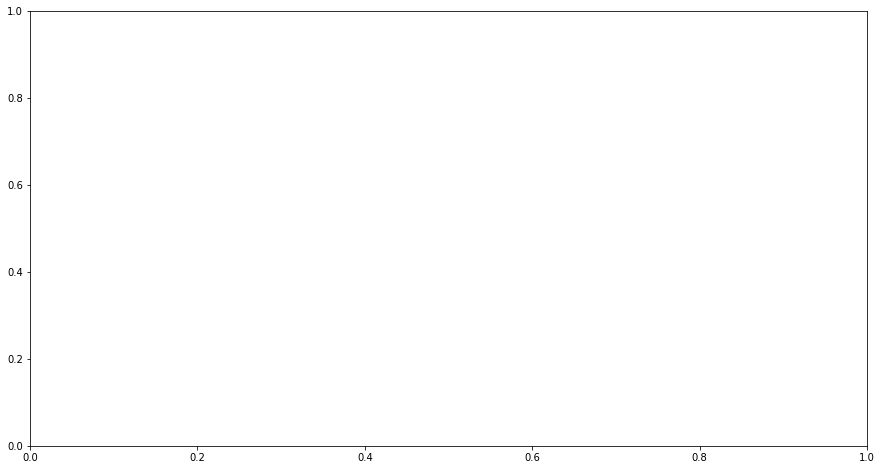

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(epochs), epoch_loss , color='r')
plt.plot(range(epochs), val_loss, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(EPOCHS), acc , color='g')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("No Augmentation")
ax.grid(True)